## Analysis of the labels from Google Cloud

In [94]:
from google.cloud import firestore
from google.cloud import storage
from tqdm import tqdm
from pathlib import Path
import json 
from geopy import distance
from collections import Counter
import geopandas
import pandas as pd
import contextily as cx

#### Initialize Connection to gcloud

In [6]:
# Initialize connections to cloud storage and database
client = storage.Client()
db = firestore.Client()
gcloud_labeling_bucket = 'street2sat-gcloud-labeling'
coll = db.collection("street2sat")

#### Obtain all jsonl files

In [69]:
jsonl_blobs = [file for file in client.list_blobs(gcloud_labeling_bucket) if file.name.endswith(".jsonl")]

print(f"Found {len(jsonl_blobs)} jsonl files in the bucket.")

Found 2 jsonl files in the bucket.


#### Loads labels into list of dictionaries 

In [72]:
# gets image data from firestore and returns the coordinates 
def get_location_from_image_path(path: str):
    query = coll.where("input_img", "==", path).limit(1).get()
    return query[0].to_dict()['coord']

# opens all the blobs, if image has labels, adds those labels to a list
def load_labels(blobs: list):
    labels = []
    for blob in blobs:
        str_rep = blob.download_as_string()
        for image_labels in tqdm(str_rep.splitlines()):
            info_image = json.loads(image_labels)
            image_path = info_image['imageGcsUri']
            info_dict = {'imageGcsUri': image_path, 'coord': get_location_from_image_path(image_path)}
            for bounding_box in info_image['boundingBoxAnnotations']:
                bounding_box_info = {**info_dict, **bounding_box}
                labels.append(bounding_box_info)
    return labels 

labels = load_labels(jsonl_blobs)
print(f'Found {len(labels)} labels total in the files.')

100%|██████████| 999/999 [00:58<00:00, 17.00it/s]

Found 240 labels total in the files.


#### Helper Functions to filter labels

In [142]:
# Filters the labels based on which ones fall within the radius specified 
def location_query(coord: tuple, radius_km: float):
    valid_labels = [lab for lab in labels if distance.distance(coord, lab['coord']).km <= radius_km]
    return valid_labels

# Returns the counts of the list of labels that is passed 
def counts_of_labels(subset_of_labels: list):
    list_for_counter = [lab['displayName'] for lab in subset_of_labels]
    counts = Counter(list_for_counter)
    return dict(counts)

# Plots the labels on a map
def make_map(subset_of_labels: list):
    df = pd.DataFrame(subset_of_labels)
    df['long'] = df.apply(lambda row: row.coord[0], axis = 1)
    df['lat'] = df.apply(lambda row: row.coord[1], axis = 1)
    gdf = geopandas.GeoDataFrame(df, geometry=geopandas.points_from_xy(df.lat, df.long, crs='EPSG:4326'))
    
    ax = gdf.to_crs('EPSG:3857').plot(
        figsize=(10, 30), 
        marker='o', 
        column='displayName', 
        categorical=True,
        markersize=15,
        cmap = 'tab10',
        legend=True
    )
    ax.set_title("Label Locations")
    return cx.add_basemap(ax, source = cx.providers.OpenStreetMap.Mapnik)


In [106]:
counts_of_labels(labels)

{'maize': 191, 'sugarcane': 4, 'banana': 31, 'cassava': 7, 'millet': 7}

In [123]:
example1 = location_query(labels[90]['coord'], 200)
counts_of_labels(example1)


{'sugarcane': 4, 'banana': 23, 'cassava': 3, 'maize': 96}

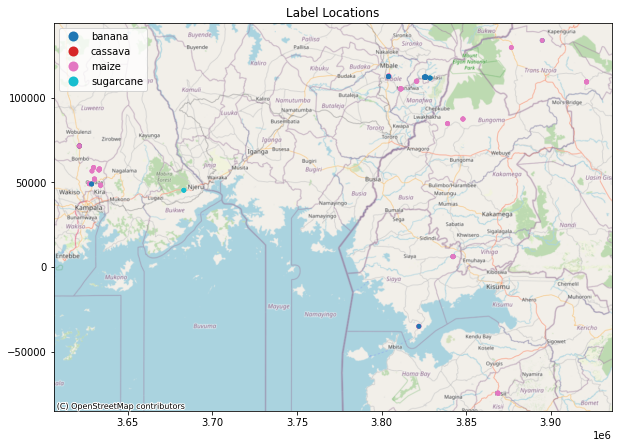

In [143]:
make_map(example1)